# Attempt at Segment Anything Model - Geospatial
* Create a new/clean environment
* Follow the following from the samgeo wepage
    * _conda install -c conda-forge mamba_
    * _mamba install -c conda-forge segment-geospatial_
* If fails, try _mamba install -c conda-forge segment-geospatial_ again

In [32]:
# Required imports
import os
import rasterio
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from rasterio.plot import show
import leafmap

# Standard SAM-geospatial
from samgeo import SamGeo, tms_to_geotiff, get_basemaps

# FastSAM-gespatial
#from samgeo import tms_to_geotiff
#from samgeo.fast_sam import SamGeo

# LangSAM model
#from samgeo.text_sam import LangSAM

## Prepare Imagery

In [2]:
wd = r'S:\Users\stidjaco\R_files\BigPanel'
image = 'F:/naipPVtest.tif'

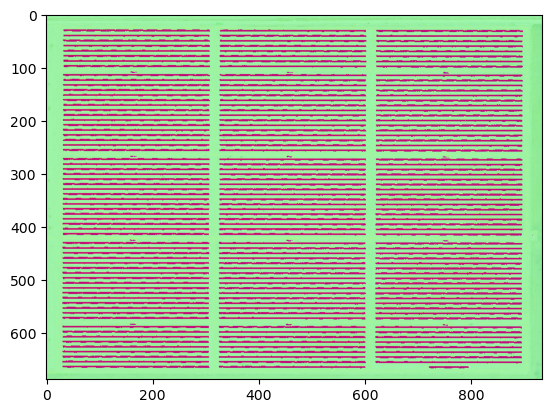

In [3]:
import numpy as np
import rasterio
import matplotlib.pyplot as plt

image_path = 'F:/naipPVtest.tif'

with rasterio.open(image_path) as src:
    img = src.read()
    img = np.moveaxis(img, 0, -1)
    img_uint8 = (img * 255).astype(np.uint8)
    
    # Check if the conversion is correct by plotting
    plt.imshow(img_uint8)
    plt.show()

from rasterio import Affine, MemoryFile
from rasterio.enums import Resampling

with MemoryFile() as memfile:
    with memfile.open(
        driver='GTiff',
        height=img_uint8.shape[0],
        width=img_uint8.shape[1],
        count=img_uint8.shape[2],
        dtype='uint8',
        transform=src.transform,
        crs=src.crs
    ) as dataset:
        dataset.write(np.moveaxis(img_uint8, -1, 0))
        
        # Save the image to a new file
        with rasterio.open('F:/naipPVtest_uint8.tif', 'w', **dataset.meta) as dst:
            dst.write(np.moveaxis(img_uint8, -1, 0))

# Now use the saved image with SamGeo
image_uint8_path = 'F:/naipPVtest_uint8.tif'

## FastSAM
* FastSAM models do not support training

## Initialize SAM

In [57]:
sam = SamGeo(model="FastSAM-x.pt")

## Set Image

In [ ]:
sam.set_image(image_uint8_path)

## Define Mask

In [92]:
sam.everything_prompt(output="mask.tif")
#sam.text_prompt(output="mask.tif", text='everything')
#sam.point_prompt(output="mask.tif", points=[(100, 100), (200, 200), (300, 300), (400, 400), (500, 500)], pointlabel=[1,1,1,1,1])

In [ ]:
sam.show_anns("mask.png")

In [ ]:
# Send to vector
sam.raster_to_vector("mask.tif", "mask.shp")

# Plot 
gdf = gpd.read_file("mask.shp")
gdf.plot()

## Regular SAM

In [4]:
# Load kwargs
sam_kwargs = {
    "points_per_side": 32,
    "pred_iou_thresh": 0.86,
    "stability_score_thresh": 0.92,
    "crop_n_layers": 1,
    "crop_n_points_downscale_factor": 2,
    "min_mask_region_area": 100,
}

# Load the model
sam = SamGeo(
    checkpoint='sam_vit_h_4b8939.pth',
    model_type='vit_h',
    device='cpu',
    sam_kwargs=sam_kwargs,
)

In [5]:
# Set file names
mask = "segment.tif"
shapefile = "segment.shp"

# Generate the mask and save it as a shp file
sam.generate(image_uint8_path, mask, batch=False, foreground=True, unique=True)
sam.tiff_to_vector(mask, shapefile)

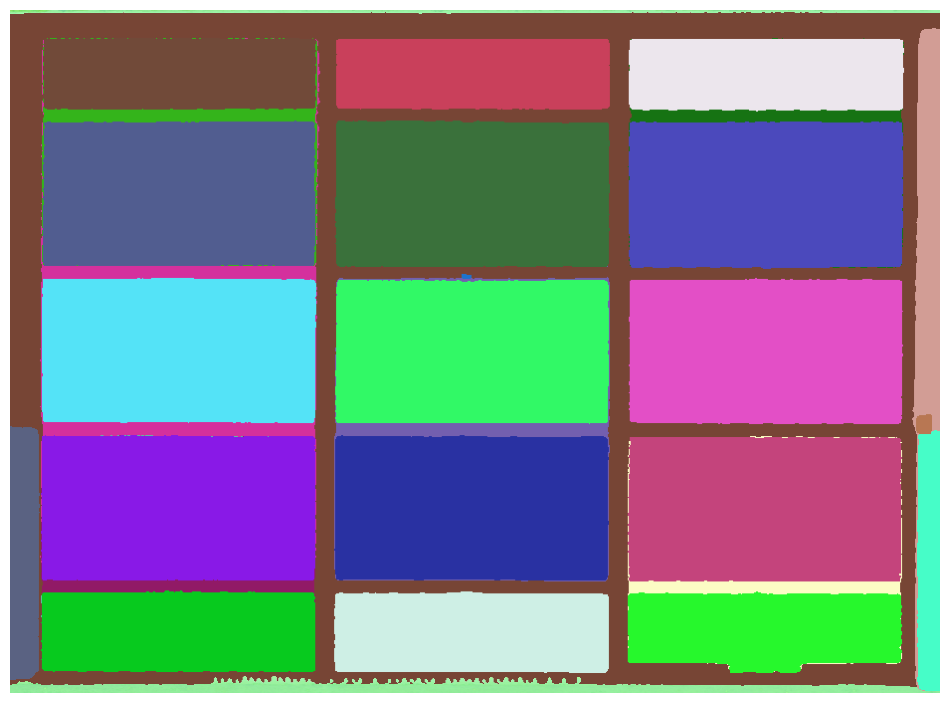

In [7]:
sam.show_anns(axis="off", alpha=1, output="water_annotations.tif")

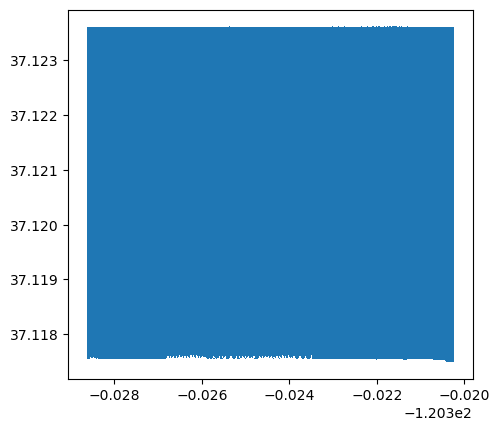

In [11]:
gdf = gpd.read_file(shapefile)
gdf.plot()

# Export shapefile 
gdf.to_file(os.path.join(wd, 'test.shp'))

## Regular SAM with RF selected training points

In [84]:
# Get sample points
pointsPath = os.path.join(wd, 'points.shp')

# Get the points
points = gpd.read_file(pointsPath)

In [85]:
# Load the model
sam = SamGeo(
    checkpoint='sam_vit_h_4b8939.pth',
    model_type='vit_h',
    device='cpu',
    automatic=False,
    sam_kwargs=None
)

In [86]:
sam.set_image(image_uint8_path)

In [87]:
# Create a list of point coordinates
point_coords = [[point.x, point.y] for point in points.geometry]

# Create a list of point labels from the class attribute 
point_labels = points['NDPVI'].tolist()

#point_coords = [[0, 0], [935, 687], [935, 0], [0, 687], [600, 300], [900, 600], [650, 350], [700, 400]]
#point_labels = [0, 0, 0, 0, 1, 1, 1, 1]
sam.predict(point_coords=point_coords, point_labels=point_labels, point_crs="EPSG:4326", output="mask.tif") # point_crs="EPSG:4326"

Some coordinates are out of the image boundary.
Removing 334 out-of-bound points.


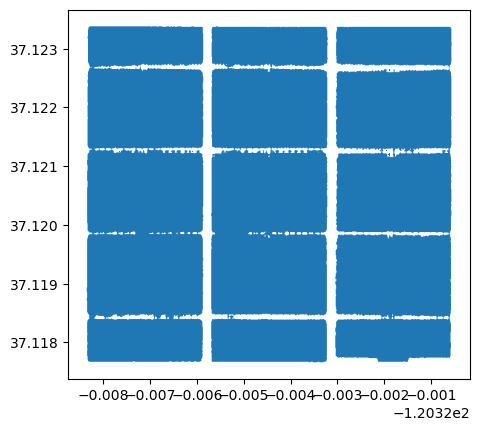

In [88]:
shapefile = "segment.shp"
sam.tiff_to_vector('mask.tif', shapefile)
gdf = gpd.read_file(shapefile)
gdf.plot()

# Export shapefile 
gdf.to_file(os.path.join(wd, 'test.shp'))